# São Tomé

This demonstration follows closely one of the ones shown in our [preprint](https://www.biorxiv.org/content/10.1101/2023.06.26.546301v1). In this application we will set to two fixed traps and import an externally-generated migration matrix. We will begin by loading all the required libraries and packages:

In [1]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
# Load libraries --------------------------------------------------------------
from os import path
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import MGSurvE as srv
import warnings
warnings.filterwarnings("ignore")


## Landscape

We will now setup some of the experiment's constants. In this case we will setup the experiment to 7 traps (`TRPS`) by default with the option to set two traps as fixed (`FXD_TRPS`) as `True`. These fixed traps will be located in two small landmasses at the north and south of the main São Tomé landscape. The experiment id `ID` is just a label for the output files, with the run id `RID` being used for iterations of the stochastic optimization process; and the `IX_SPLIT` used to separate to separate sites in São Tomé from the ones in the island of Príncipe. Finally, we will create a folder to export our results into.

In [2]:
(TRPS_NUM, FXD_TRPS) = (12, True)
# Experiment ID (RID) and stochastic iteration id (RID) -----------------------
(ID, RID) = ('STP', 0)
IX_SPLIT = 27
# Output folder ---------------------------------------------------------------
OUT_PTH = './out/'
srv.makeFolder(OUT_PTH)

We need to read our points coordinates. These positions are stored in a CSV file as *longitude/latitude* format, so we will load them into a pandas dataframe and set them to the same point-type (`t`):

In [3]:
sites = pd.read_csv(path.join('../../data/', 'STP_LatLonN.csv'))
sites['t'] = [0]*sites.shape[0]

Our original CSV file contains the information for both São Tomé and Príncipe, but in this example we will be focusing on the main São Tomé land, so we will split the dataframe to get the positions we are interested on (`SAO_TOME_LL`). At the same time, we will get the landscape bounding box (`SAO_bbox`), center (`SAO_cntr`), and the ID of the nodes where we want our fixed traps to be in (`SAO_FIXED`):

In [4]:
# Get longitude-latitudes for main island -------------------------------------
SAO_TOME_LL = sites.iloc[IX_SPLIT:]
# Get bounding box ------------------------------------------------------------
SAO_bbox = (
    (min(SAO_TOME_LL['lon']), max(SAO_TOME_LL['lon'])),
    (min(SAO_TOME_LL['lat']), max(SAO_TOME_LL['lat']))
)
# Get centroid ----------------------------------------------------------------
SAO_cntr = [i[0]+(i[1]-i[0])/2 for i in SAO_bbox]
SAO_LIMITS = ((6.41, 6.79), (-0.0475, .45))
# Get sites IDs for fixed traps -----------------------------------------------
SAO_FIXED = [51-IX_SPLIT, 239-IX_SPLIT]
FXD_NUM = len(SAO_FIXED)

We now import the migration matrix and split it to get the São Tomé subset of transitions (`SAO_TOME_MIG`):

In [5]:
migration = np.genfromtxt(
    path.join('../../data/', 'STP_MigrationN.csv'), delimiter=','
)
# Spliting up Sao Tome and making sure rows are normalized --------------------
msplit = migration[IX_SPLIT:,IX_SPLIT:]
SAO_TOME_MIG = normalize(msplit, axis=1, norm='l1')

We now setup the traps. In this case we will set all the traps to the same type `0`. Generally speaking, the initial position in terms of longitud and latitude is not important in this case as we will be doing discrete optimization, but the current version of MGSurvE still needs some positions vector to be provided (will likely get deprecated in future releases). Something that is important, however, is that we setup our fixed traps in the right node id for them to be located in the small masses of land at the north and south of the island (`SAO_FIXED`), so we setup a vector of a number of traps that can be placed at whichever node we want (`0`, in this case), and two traps that are located in specific nodes (`SAO_FIXED` which are `[24, 212]`).

In [6]:
(initTyp, initFxd) = ([0]*TRPS_NUM, [0]*TRPS_NUM)
if FXD_TRPS:
    initFxd = ([0]*(TRPS_NUM-FXD_NUM) + [1]*FXD_NUM)
# Initialize the position of traps (not strictly needed) ----------------------
(initLon, initLat) = ([[SAO_cntr[0]]*TRPS_NUM, [SAO_cntr[1]]*TRPS_NUM])
# Initialize traps to nodes IDs -----------------------------------------------
sid = [0]*(TRPS_NUM-FXD_NUM) + SAO_FIXED 

With this in place, we can setup our trap kernel and our traps dataframe:

In [7]:
tKer = {0: {'kernel': srv.exponentialDecay, 'params': {'A': 0.5, 'b': 0.041674}}}
# Initialize traps ------------------------------------------------------------
traps = pd.DataFrame({
    'sid': sid, 'lon': initLon, 'lat': initLat, 
    't': initTyp, 'f': initFxd
})

We can now initialize our landscape with the info we gathered from our previous steps:

In [8]:
lnd = srv.Landscape(
    SAO_TOME_LL, migrationMatrix=SAO_TOME_MIG,
    traps=traps, trapsKernels=tKer, 
    landLimits=SAO_LIMITS
)
bbox = lnd.getBoundingBox()
trpMsk = srv.genFixedTrapsMask(lnd.trapsFixed)

And let's plot our traps and landscape now!

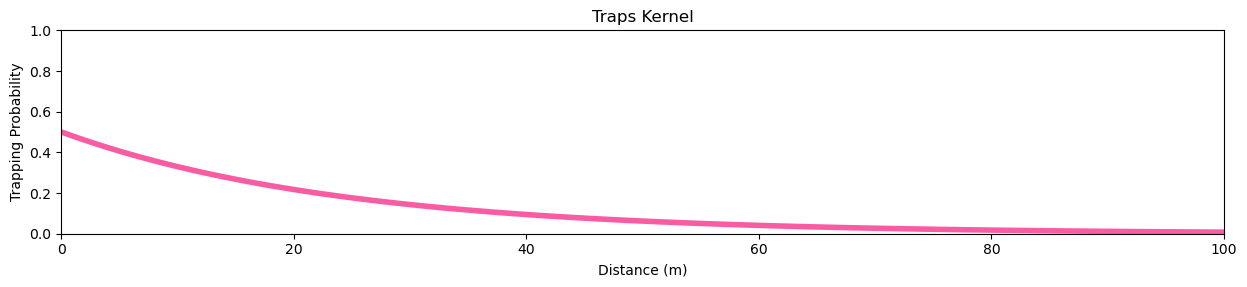

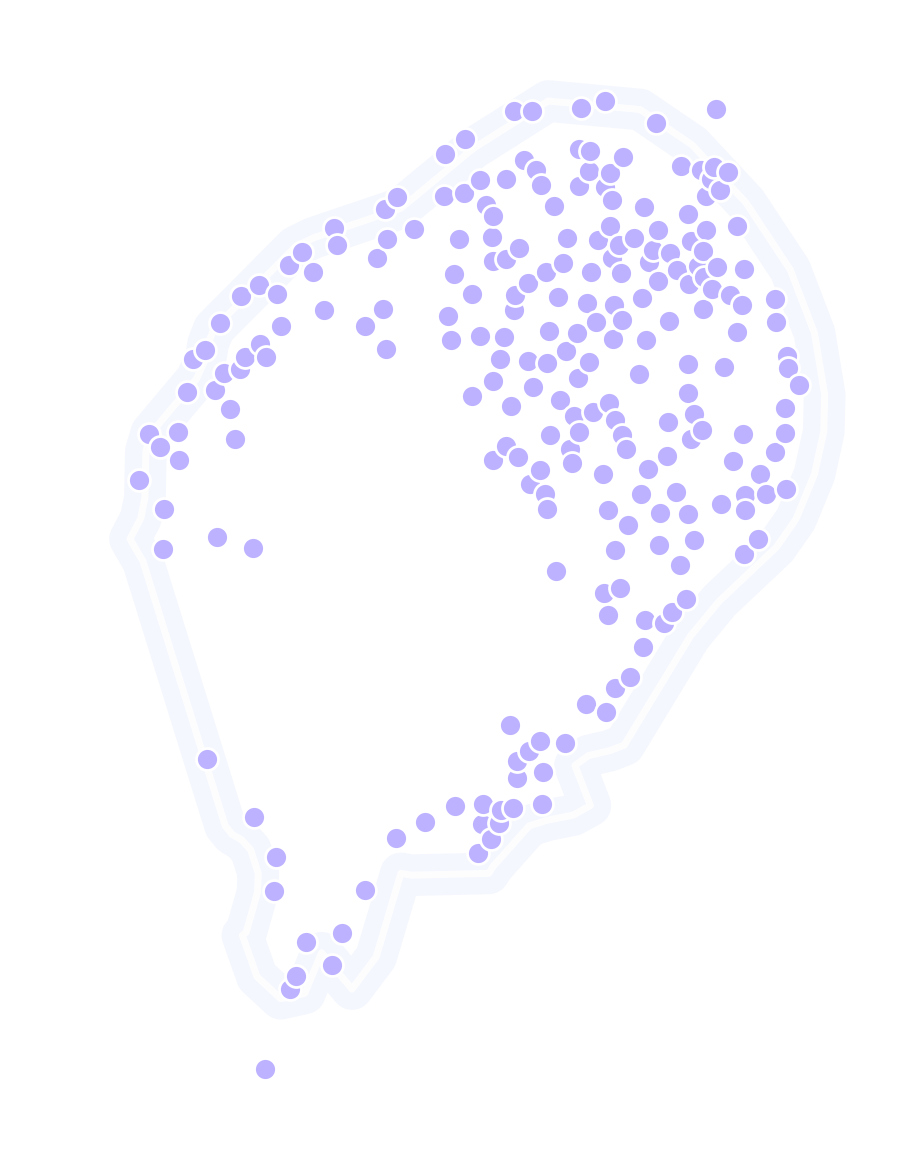

In [9]:
# Plot Traps Kernels ----------------------------------------------------------
(fig, ax) = plt.subplots(1, 1, figsize=(15, 5), sharey=False)
(fig, ax) = srv.plotTrapsKernels(fig, ax, lnd, distRange=(0, 100), aspect=.175)
ax.set_title("Traps Kernel")
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Trapping Probability")
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_KER.png'.format(ID, TRPS_NUM, RID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)
# Plot Landscape --------------------------------------------------------------
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=250)
lnd.plotLandBoundary(fig, ax)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    path.join(OUT_PTH, '{}_{:02d}_CLN.png'.format(ID, TRPS_NUM)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)

## Optimization

We now turn to the optimization section of our code. For this demo, let's setup a low number of generations so that it doesn't take too long to run (around 50 or 100), with the summary statistic for our fitness function as the mean of the expected times for mosquitoes to fall into traps (`np.mean`). We will use some mutation, crossover, and selection parameters that we have found useful by trial and error. Some general thoughts on the selection of these parameters, though:
* We want the population size to grow proportionally with the number of variables to optimize, but keeping it as low as possible so that it's not very computationally intensive, and allows for exploration.
* The mutation probability of each potential solution (`mutpb`) should be high enough to allow for exploration but not so large that the optimization fails to converge (same goes for the probability of mutation of each individual allele in a chromosome `indpb`).
* The crossover probability between potential solutions (`cxpb`) allows for the exchange of alleles between good solutions in hopes that the mix results in a better fitness value, so we should have this value as high as we want but not so much that we are sampling too often.

In [10]:
(GENS, GA_SUMSTAT, VERBOSE) = (500, np.mean, False)
# Parameters for the genetic algorithm internal operation ---------------------
POP_SIZE = int(10*(lnd.trapsNumber*1.5))
(MAT, MUT, SEL) = (
    {'cxpb':  0.300, 'indpb': 0.35}, 
    {'mutpb': 0.375, 'indpb': 0.50},
    {'tSize': 3}
)

With that, we can now instantiate and run our GA algorithm! Keep in mind that it will take some time to finish, but look at the `min` column, which should be slowly getting smaller with each iteration (generation) of the algorithm:

In [11]:
outer = GA_SUMSTAT
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lnd, pop_size=POP_SIZE, generations=GENS, verbose=VERBOSE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': outer}
)

And let's export our results to disk for future use:

In [12]:
srv.exportLog(logbook, OUT_PTH, '{}D-{:02d}-{:02d}_LOG'.format(ID, TRPS_NUM, RID))
srv.dumpLandscape(lnd, OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), fExt='pkl')

## Analysis

For this demonstration, we will plot the evolution of our genetic algorithm in finding the most optimum solution. The region shaded in blue spans the best solution (bottom) to the worst one (top), with the mean being plotted in white somewhere between these values. For a GA it's important that the best solution doesn't bounce around too much and that it keeps improving as generations go on, but it's also important to have some variability so that exploration is taking place, so a reasonably wide envelope is generally a good sign for our applications:

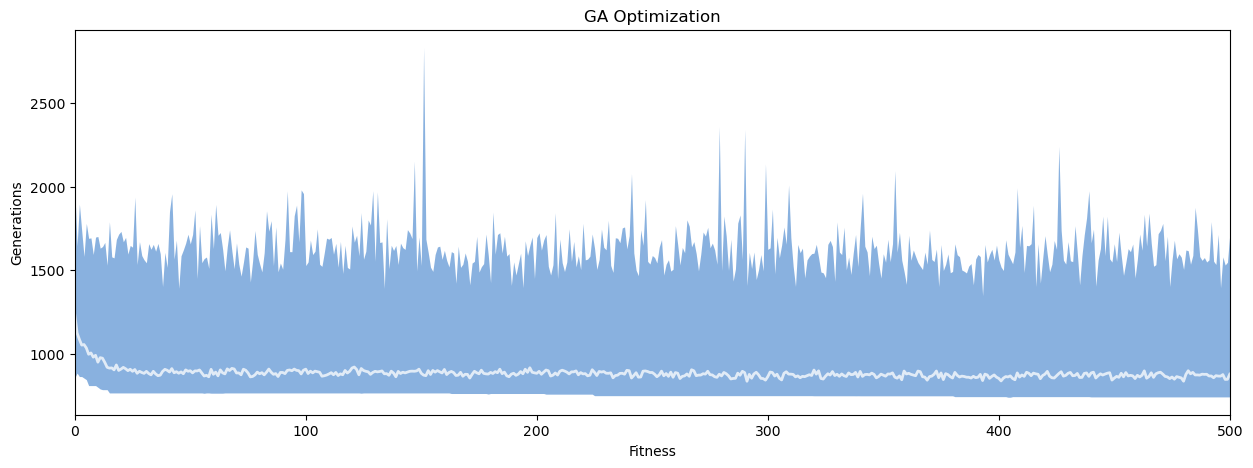

In [13]:
log = pd.DataFrame(logbook)
log.rename(columns={'median': 'avg'}, inplace=True)
(fig, ax) = plt.subplots(1, 1, figsize=(15, 5), sharey=False)
ax.set_title("GA Optimization")
ax.set_xlabel("Fitness")
ax.set_ylabel("Generations")
srv.plotGAEvolution(
    fig, ax, log,
    colors={'mean': '#ffffff', 'envelope': '#1565c0'},
    alphas={'mean': .75, 'envelope': 0.5},
    aspect=1/3
)
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_GA.png'.format(ID, TRPS_NUM, RID)),  
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)

Finally, let's plot our optimized landscape!

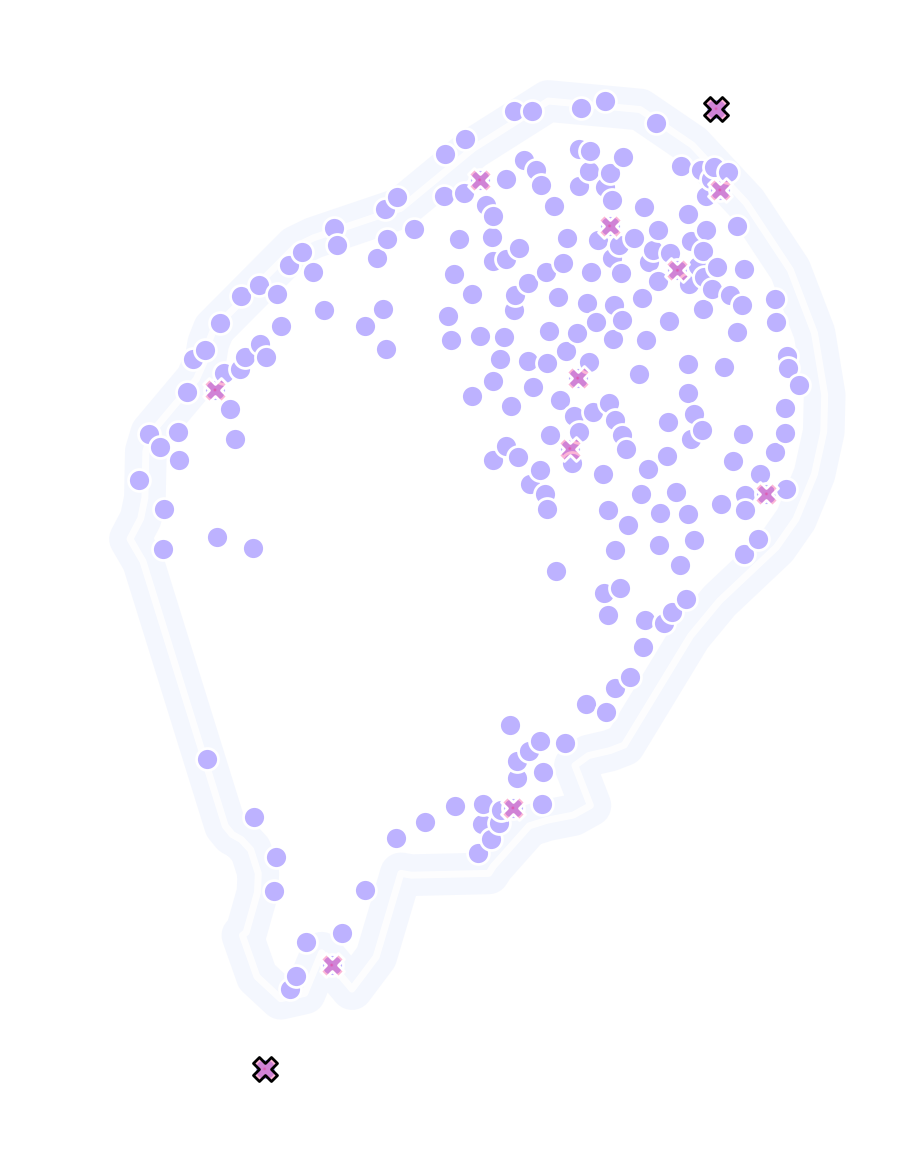

In [14]:
lnd = srv.loadLandscape(
    OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), 
    fExt='pkl'
)
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=250)
lnd.plotTraps(
    fig, ax, 
    zorders=(30, 25), transparencyHex='55', 
    proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
lnd.plotLandBoundary(fig, ax)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_TRP.png'.format(ID, TRPS_NUM, RID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=400
)
